In [1]:
import re
import json
import torch
import string
import numpy as np
from tqdm import tqdm
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# 定义颜色的ANSI代码
RED = '\033[91m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RESET = '\033[0m'  # 重置颜色

def plot_images(image_paths):
    num_images = len(image_paths)
    
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    
    for i, image_path in enumerate(image_paths):
        img = mpimg.imread(image_path)

        # 如果是灰度图（2D），扩展为 RGB
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        # 如果是带 alpha 通道的 RGBA 图，去掉 alpha
        elif img.shape[2] == 4:
            img = img[:, :, :3]

        ax = axes if num_images == 1 else axes[i]
        ax.imshow(img)
        ax.set_title(f'Image {i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def extract_and_run_code(input_str: str):
    # match = re.search(r"<code>(.*?)</code>", input_str, re.DOTALL)
    match = re.search(r"<code>\s*```python(.*?)```.*?</code>", input_str, re.DOTALL)

    if match:
        code_str = match.group(1)
        # print("提取的代码如下：")
        # print(code_str)

        # 定义环境
        # global_env = {
        #     "__builtins__": __builtins__,  # 允许 import
        # }
        local_vars = {}
        try:
            exec(code_str,  globals(), local_vars)
            return True, local_vars
        except Exception as e:
            print(f"Code Error {e}")
            return False, e
    else:
        print("Code is not extracted successfully")
        return False, "Code is not extracted successfully"
    
def extract_problems(text):
    match = re.search(r"<problem>\s*\{(.*?)\}\s*</problem>", text, re.DOTALL)
    if not match:
        return []

    content = match.group(1)
    # 提取所有用英文单引号包裹的单词
    problems = re.findall(r"'([^']+)'", content)
    return sorted(problems)


def extract_coordinates(text):
    pattern = r'\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]'
    matches = re.findall(pattern, text)
    # 转换为整数列表格式
    coordinates = [list(map(int, match)) for match in matches]
    return coordinates

/fs-computility/mllm/liuziyu/miniconda3/envs/r1-v/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. <problem> Describe the image issue from {'rotate', 'dark', 'overexposure', 'blur', 'noise'} </problem>
system_prompt = """# Role
You are a step-by-step image processing assistant.
Your task is to solve an image-based task by applying OpenCV operations one step at a time, optionally using a reasoning chain.

# Output Format
At each step, output **only one** of the following, preceded by a <think> tag:
1. <problem> Describe the image issue from {'rotation90', 'rotation180', 'dark', 'overexposure', 'blur', 'noise', 'crop', 'none'} </problem>
2. <code> OpenCV code to process and save the image </code>
3. <answer> Final answer based on the processed image </answer>

# Image Processing Rules
- Always read from `'path_to_input_image.jpg'` and write to `'path_to_output_image.jpg'`.

# Output Format (strict):
Always begin with <think>. Then, depending on current reasoning chain, output one of the following:

## 1. If this is the first step and only the query is given, output in the following format:
<think> Initial analysis of the image issue. </think>
<problem> {'problem1', ...} </problem>

## 2. If <problem> is given, continue with image operations:
<think> Explain what to fix next. </think>
<code>
```python
One Python code block using OpenCV to perform the operation, and save the processed images.
```
</code>

## 3. If ready to conclude:
<think> Summarize the processing steps and provide the result or outcome </think> 
<answer> Final answer, as briefly as possible</answer>

# Current reasoning chain:
"""


In [4]:
model_name = "/share_models/Qwen2.5-VL-7B-Instruct_GRPO_agent_code_1_2k_new2_gpu8/checkpoint-1400/"

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map='cuda:0',
)
processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 4/4 [00:08<00:00,  2.20s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
with open('./cases/coding_case.json') as file:
    coding_case = json.load(file)
print(len(coding_case))

6


In [6]:
"""
The model outputs one step at a time during the reasoning process.
Each step includes the next action, which could be analyzing the image, writing code, or providing an answer.
After each step, the context is updated by adding the model's previous reasoning to the history.
When handling code, any file paths or bounding boxes in the code are replaced with actual values.
"""

"\nThe model outputs one step at a time during the reasoning process.\nEach step includes the next action, which could be analyzing the image, writing code, or providing an answer.\nAfter each step, the context is updated by adding the model's previous reasoning to the history.\nWhen handling code, any file paths or bounding boxes in the code are replaced with actual values.\n"

  0%|          | 0/6 [00:00<?, ?it/s]

########################################


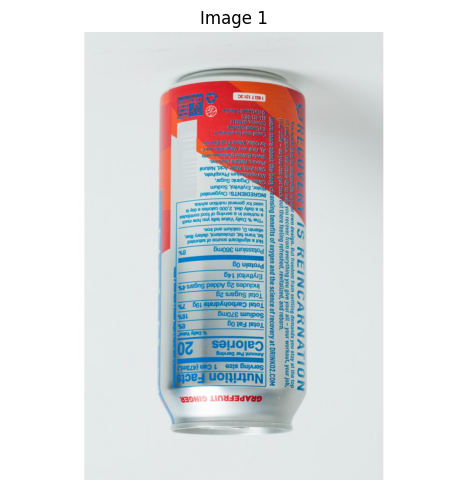

<query> What is the serving size of the beverage? </query>
<think> The image appears to be a beverage can with nutritional information printed on it. To determine the serving size, we need to identify the text that specifies the amount of the beverage per serving.</think>
<problem> {'rotation180'} </problem>
<think> The image needs to be rotated 180 degrees to make the text legible for identifying the serving size.</think>
<code>
```python
import cv2

# Load the image
image = cv2.imread('path_to_input_image.jpg')

# Rotate the image 180 degrees
rotated_image = cv2.rotate(image, cv2.ROTATE_180)

# Save the processed image
cv2.imwrite('path_to_output_image.jpg', rotated_image)
```
</code>


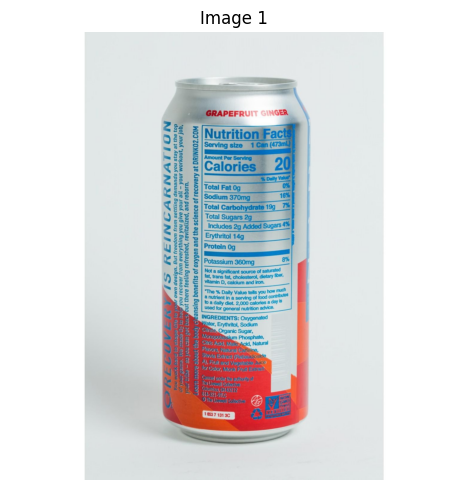

 17%|█▋        | 1/6 [00:30<02:32, 30.58s/it]

<think> The image has been rotated 180 degrees to make the text legible. Now we can easily identify the serving size of the beverage.</think>
<answer> 1 Can (473mL) </answer>
Ground Truth: ['1 Can (473ml)']
Pred Answer: 1 Can (473mL)
########################################


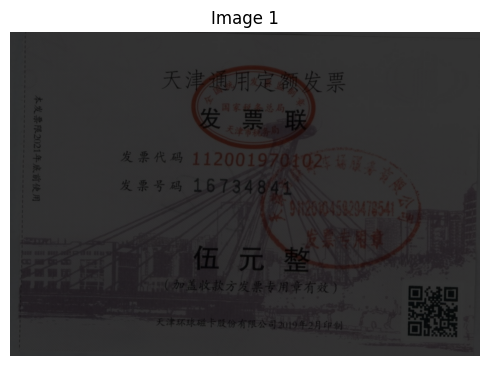

<query> 从图中提取: 发票号码, 发票代码 </query>
<think> Initial analysis of the image issue. </think>
<problem> {'dark'} </problem>
<think> The image appears to be dark, making it difficult to read the text clearly. We need to enhance the image's brightness and contrast to improve readability.</think>
<code>
```python
import cv2
import numpy as np

# Load the image
image = cv2.imread('path_to_input_image.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to enhance contrast
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Save the processed image
cv2.imwrite('path_to_output_image.jpg', thresh)
```
</code>


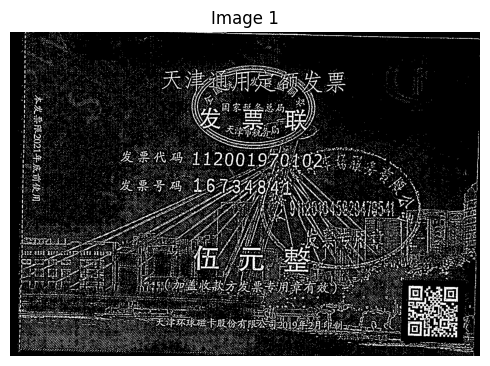

 33%|███▎      | 2/6 [01:03<02:08, 32.03s/it]

<think> The image has been enhanced for better readability, but we still need to extract the specific information requested: 发票号码 and 发票代码.</think>
<answer> 发票号码: 16734841, 发票代码: 112001970102</answer>
Ground Truth: ["{'发票号码': '16734841', '发票代码': '112001970102'}"]
Pred Answer: 发票号码: 16734841, 发票代码: 112001970102
########################################


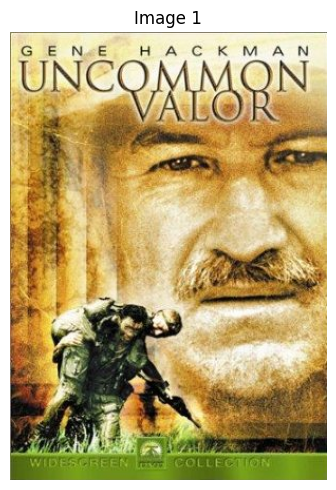

<query> What is the title of the movie featured in the image? </query>
<think> The image appears to be a movie poster for "Uncommon Valor," featuring Gene Hackman. The title is clearly visible at the top of the image.</think>
<problem> {'none'} </problem>


 50%|█████     | 3/6 [01:10<01:02, 20.74s/it]

<think> The image is clear and the title is visible at the top of the poster. No further processing is needed.</think>
<answer> Uncommon Valor </answer>
Ground Truth: ['Uncommon Valor']
Pred Answer: Uncommon Valor
########################################


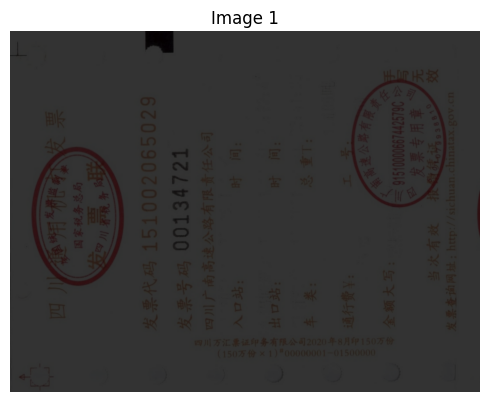

<query> 从图中提取: 发票号码, 发票代码, 金额 </query>
<think> Initial analysis of the image issue. </think>
<problem> {'rotation90', 'dark'} </problem>
<think> The image appears to be rotated and darkened, making it difficult to read the text clearly. First, we need to rotate the image to correct its orientation and then enhance its brightness and contrast to improve readability.</think>
<code>
```python
import cv2
import numpy as np

# Load the image
image = cv2.imread('path_to_input_image.jpg')

# Rotate the image by 90 degrees clockwise
rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

# Enhance the brightness and contrast
enhanced_image = cv2.convertScaleAbs(rotated_image, alpha=1.5, beta=50)

# Save the processed image
cv2.imwrite('path_to_output_image.jpg', enhanced_image)
```
</code>


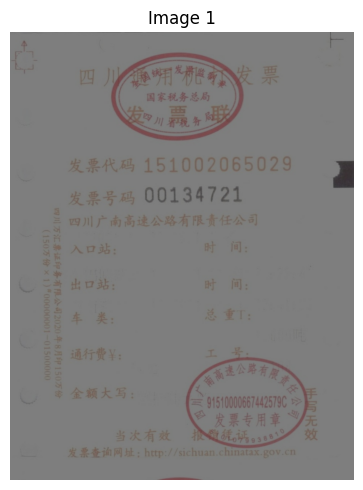

 67%|██████▋   | 4/6 [01:49<00:55, 27.76s/it]

<think> The image has been rotated and darkened, which makes it difficult to read the text. We have already rotated the image by 90 degrees clockwise and enhanced its brightness and contrast to improve readability. Now, we can extract the required information from the image.</think>
<answer> 发票号码: 00134721, 发票代码: 151002065029, 金额大写: </answer>
Ground Truth: ["{'发票号码': '00134721', '发票代码': '151002065029', '金额': '#'}"]
Pred Answer: 发票号码: 00134721, 发票代码: 151002065029, 金额大写:
########################################


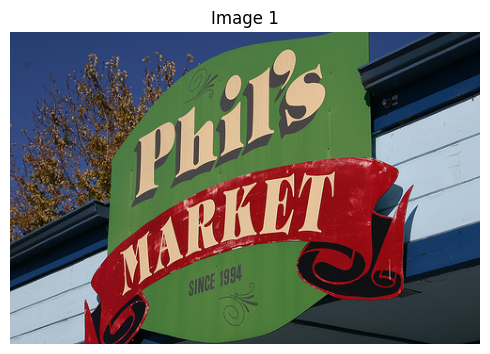

<query> Recognize the text within the [366, 723, 506, 851] of the image. The coordinates have been normalized ranging from 0 to 1000 by the image width and height.  </query>
<think> The image appears clear enough for text recognition without any issues related to rotation, darkness, overexposure, blur, noise, or cropping. The text "Phil's Market Since 1994" is already legible.</think>
<problem> {'crop'} </problem>
<think> The image appears clear enough for text recognition without any issues related to rotation, darkness, overexposure, blur, noise, or cropping. The text "Phil's Market Since 1994" is already legible.</think>
<code>
```python
import cv2

# Load the image
image = cv2.imread('path_to_input_image.jpg')

# Define the cropping coordinates
x_min, y_min, x_max, y_max = 366, 723, 506, 851

# Crop the image
cropped_image = image[y_min:y_max, x_min:x_max]

# Save the cropped image
cv2.imwrite('path_to_output_image.jpg', cropped_image)
```
</code>


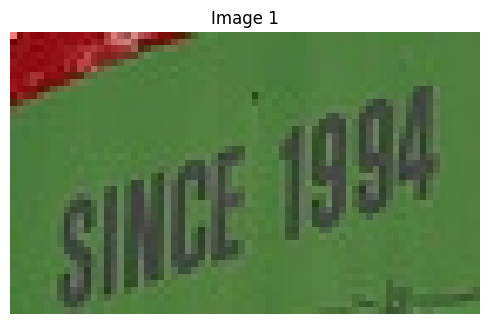

 83%|████████▎ | 5/6 [02:15<00:27, 27.25s/it]

<think> The image has been successfully cropped around the text "Since 1994". Now we can proceed to extract the text from the cropped region.</think>
<answer> Since 1994</answer>
Ground Truth: ['SINCE 1994']
Pred Answer: Since 1994
########################################


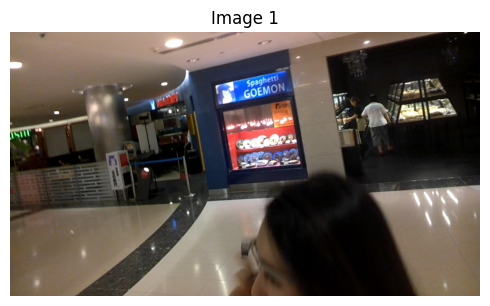

<query> Recognize the text within the [489, 155, 595, 259] of the image. The coordinates have been normalized ranging from 0 to 1000 by the image width and height.  </query>
<think> The task requires identifying the text within the specified bounding box. This can be achieved by cropping the image according to the provided coordinates and then using OCR (Optical Character Recognition) to extract the text.</think>
<problem> {'crop'} </problem>
<think> The task requires identifying the text within the specified bounding box. This can be achieved by cropping the image according to the provided coordinates and then using OCR (Optical Character Recognition) to extract the text.</think>
<code>
```python
import cv2
import numpy as np

# Load the image
image = cv2.imread('path_to_input_image.jpg')

# Define the bounding box coordinates
x_min, y_min, x_max, y_max = 489, 155, 595, 259

# Crop the image
cropped_image = image[y_min:y_max, x_min:x_max]

# Save the cropped image
cv2.imwrite('path_to

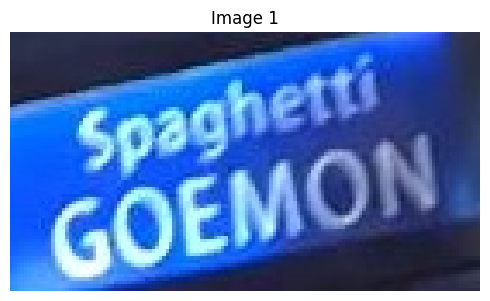

100%|██████████| 6/6 [02:50<00:00, 28.34s/it]

<think> The task requires identifying the text within the specified bounding box. This can be achieved by cropping the image according to the provided coordinates and then using OCR (Optical Character Recognition) to extract the text.</think>
<answer> Spaghetti GOEMON</answer>
Ground Truth: ['Spaghetti\nGOEMON']
Pred Answer: Spaghetti GOEMON


In [7]:
for item in tqdm(coding_case):
    print("########################################")
    if item['type'][0] == 'crop':
        input_image_path = './cases/' + item['ori_image_path']
    else:
        input_image_path = './cases/' + item['processed_image_path']
    query = item['question']
    data_type = item['type']

    # The location where the processed image is cached during image processing.
    output_image_path = './cached.jpg'
    input_text = system_prompt + f'<query> {query} <query>'
    plot_images([input_image_path])
    print(f'<query> {query} </query>')

    messages = [
        { "role": "user", 
            "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
    ]

    # Exit the loop if iteratioin>5 to prevent an infinite loop.
    for _ in range(5): 

        ###### inference ######
        text = processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        image_inputs, video_inputs = process_vision_info(messages)
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        inputs = inputs.to(model.device)
        generated_ids = model.generate(**inputs, max_new_tokens=1024)
        generated_ids_trimmed = [
            out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        output_text = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        result = output_text[0]

        ##### Determine the next action based on the tags in the response, including <problem>, <coding>, and <answer>. ######
        if '<answer>' in result:
            try:
                print(result)
                match = re.search(r"<answer>\s*(.*?)\s*</answer>", result)
                if match:
                    answer_content = match.group(1).strip()
                print("Ground Truth: " + str(item['answers']))
                print("Pred Answer: " + answer_content)
                break
            except Exception as e:
                break
        if '<problem>' in result:
            print(result)
            ##### messages updata ######
            problems_list = extract_problems(result)  # Extract the problem identified by the model and update the context accordingly.
            if problems_list[0] == 'crop':
                input_text = input_text + '\n' + result + '\n' + f'<tips> We now need to crop the image. Please provide the Python code. Use [x_min, y_min, x_max, y_max] to represent the bounding box coordinates. </tips>' + '\n'
            elif problems_list[0] == 'none':
                input_text = input_text + '\n' + result + '\n' + f'<tips> The image has no issues, so no code is needed in the next step. You can directly provide the answer. </tips>'
            else:
                input_text = input_text + '\n' + result + '\n' + f'<tips> Now that we have identified the issue in the image: {problems_list}, please proceed to address it by outputting the python code. </tips>' + '\n'
            messages = [
                {"role": "user", "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
            ]
        if '<code>' in result:
            print(result)
            """
            Replace the image path in the code with the actual image path, 
            replace the bbox with the corresponding coordinates, 
            execute the code and return the result. 
            add the result to the context, then input it into the model for the next iteration.
            """
            if problems_list[0] != 'crop':
                # For distortion types, replace the image path accordingly.
                result_replace_path = result.replace('path_to_input_image.jpg', input_image_path).replace('path_to_output_image.jpg', output_image_path)
                flage, code_results = extract_and_run_code(result_replace_path)
            else:
                # For the crop type, the coordinates in the code need to be replaced. Since Qwen2.5 supports actual pixel coordinates, perform coordinate conversion first.
                result_replace_path = result.replace('path_to_input_image.jpg', input_image_path).replace('path_to_output_image.jpg', output_image_path)
                img_pil = Image.open(input_image_path).convert("RGB")  # 确保为RGB格式
                img = np.array(img_pil)
                width, height = img_pil.size
                bbox = extract_coordinates(item['question'])[0]
                x_min = int(bbox[0] / 1000 * width)
                y_min = int(bbox[1] / 1000 * height)
                x_max = int(bbox[2] / 1000 * width)
                y_max = int(bbox[3] / 1000 * height)
                pattern = r'\[\s*((?:[^\[\]:]|(?:\[[^\[\]]*\]))+?)\s*:\s*((?:[^\[\]:]|(?:\[[^\[\]]*\]))+?)\s*,\s*((?:[^\[\]:]|(?:\[[^\[\]]*\]))+?)\s*:\s*((?:[^\[\]:]|(?:\[[^\[\]]*\]))+?)\s*\]'
                replacement = f'[{y_min}:{y_max}, {x_min}:{x_max}]'
                result_replace_path_code = re.sub(pattern, replacement, result_replace_path)
                flage, code_results = extract_and_run_code(result_replace_path_code)
            if flage==True:
                plot_images([output_image_path])
                input_text = input_text + '\n' + result
                input_image_path = output_image_path
                ##### messages updata ######
                messages = [
                    {"role": "user", "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
                ]
            else:
                input_text = input_text + '\n' + result
                ##### messages updata ######
                messages = [
                    {"role": "user", "content": [{"type": "image","image": input_image_path}, {"type": "text", "text": input_text}]}
                ]